<h2 align=center> Toxic Comments Classification using 1D CNN with Keras</h2>

### Task 1: Import Packages and Functions

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.2.0


### Task 2: Load and Explore Data

In [3]:
# Load data
train_df = pd.read_csv('train.csv').fillna(' ')
train_df.sample(10, random_state = 1)

,comment_text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
123190,Is this the bizarro world? Removing content is...,0
33626,"Well, WP:RS says that articles should use reli...",0
1150,Oh hear me go someone removes all my pages i g...,0
48633,can't believe this article was deleted\nI'm su...,0
42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


In [4]:
x = train_df['comment_text'].values
print(x)

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [5]:
# View few toxic comments
train_df.loc[train_df['toxic']==1].sample(10)

,comment_text,toxic
147155,Trouted \n\nYou have been trouted for: ?B/ for...,1
111385,Go TO hell \n\nYour message was bull. Why don'...,1
132373,"""\n\n You're a jerk \n\nMark Recchi definitely...",1
73414,the long count is NOT a calendar ... POD ... i...,1
135440,You're ridiculous \n\nIt's obvious that you ha...,1
149313,hey \n\nwhy must you be such a shithole? fuck off,1
44943,you are dumb \n\nyou are dumb,1
106541,What the **** is this ****? \n\nWikipedia has ...,1
10406,The Wack Pack \n\nYou're fucking insane and dr...,1
108060,hi \n\nhi gay homo thanks 4 trying 2 block me ...,1


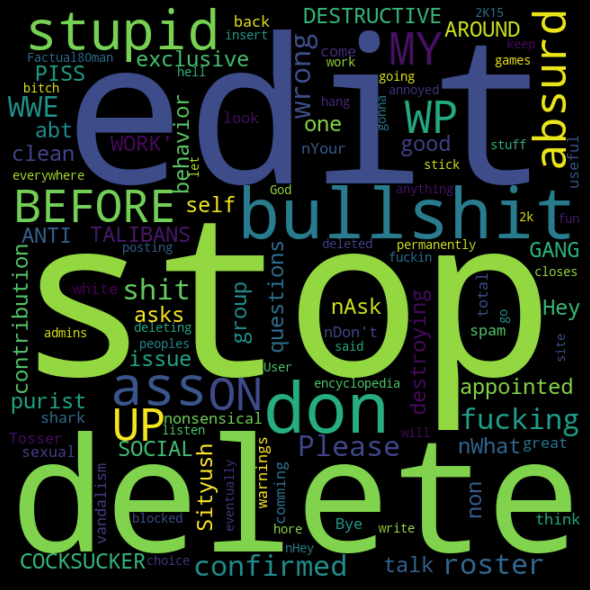

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [7]:
y = train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


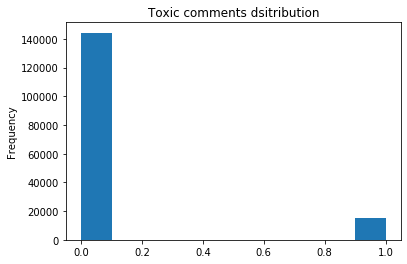

In [8]:
# Plot frequency of toxic comments
train_df['toxic'].plot(kind = 'hist',title = 'Toxic comments dsitribution')

In [9]:
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

### Task 3: Data Prep — Tokenize and Pad Text Data

In [10]:
#max_features - number of most common words from dataset
max_features = 20000
#max_text_length = maximum length of a particular sequence or comment can have
max_text_length = 400

In [11]:
"""Vectorize a text corpus by turning each text into a sequence 
of integer and each integer being index of a token in a Dict and value 
is the word"""
x_tokenizer = text.Tokenizer(max_features) # select only top 20000 words
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized, maxlen = max_text_length)

### Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [12]:
wget http://nlp.stanford.edu/data/glove.6B.zip
unzip -q glove.6B.

embedding_dim = 100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coeffs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coeffs
f.close()
print(f'Found {len(embeddings_index)} word vectore.')


Found 400000 word vectore.


In [13]:
#Embedding matrix of size 20000x400
embedding_matrix = np.zeros((max_features, embedding_dim))
for word,index in x_tokenizer.word_index.items():
    if index > max_features -1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

### Task 5: Create the Embedding Layer

In [15]:
model = Sequential()
#next we use the GloVe embeddings and transfer the weights to our model
model.add(Embedding(max_features,
                   embedding_dim,
                   embeddings_initializer = tf.keras.initializers.Constant(
                   embedding_matrix),
                   trainable = False))
model.add(Dropout(0.2))

### Task 6: Build the Model

In [16]:
filters = 250
kernal_size = 3
hidden_dims = 250

In [18]:
model.add(Conv1D(filters,
                 kernal_size,
                padding = 'valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                5,
                padding = 'valid',
                activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation = 'relu'))
model.add(Dropout(0.2)) #regularization to prevent overfitting

model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)              

In [20]:
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

### Task 7: Train Model

In [21]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y,
                                                 test_size = 0.15)

In [22]:
batch_size = 32
epochs = 3

model.fit(x_train, y_train,
         batch_size = batch_size,
         epochs = epochs,
         validation_data = (x_val, y_val))

Epoch 1/3
4239/4239 [==============================] - 80s 19ms/step - loss: 0.1534 - accuracy: 0.9449 - val_loss: 0.1300 - val_accuracy: 0.9504
Epoch 2/3
4239/4239 [==============================] - 80s 19ms/step - loss: 0.1328 - accuracy: 0.9511 - val_loss: 0.1224 - val_accuracy: 0.9540
Epoch 3/3
4239/4239 [==============================] - 80s 19ms/step - loss: 0.1248 - accuracy: 0.9533 - val_loss: 0.1288 - val_accuracy: 0.9543


### Task 8: Evaluate Model

In [23]:
test_df = pd.read_csv('test.csv')

In [25]:
x_test = test_df['comment_text'].values

In [26]:
#we do padding now using same tokenizer as earlier
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen = max_text_length)

In [27]:
y_testing = model.predict(x_testing, verbose = 1, batch_size = 32)

4787/4787 [==============================] - 34s 7ms/step


In [28]:
y_testing.shape

(153164, 1)

In [29]:
y_testing[0]

array([0.9995161], dtype=float32)

In [31]:
test_df['Toxic'] = ['Not Toxis' if i < 0.5 else 'Toxic' for i in y_testing]
test_df[['comment_text','Toxic']].sample(20)

,comment_text,Toxic
106129,== RE: The Shootist == \n\n Thanks for editing...,Not Toxis
45261,how in the name of good fuck did shawn micha...,Toxic
38085,:Don't suggest that. Space-nazis will get upse...,Not Toxis
59748,"*In other words... spite, gloating, taunting,...",Not Toxis
152732,considered personal use and will not result in...,Not Toxis
68578,== GADDAMIT BITCH!! == \n\n The Rules Say I Ca...,Toxic
129053,== Deletion discussion about Pop Songs for Roc...,Not Toxis
34421,:::Thank you Friendly Stalker. ) As suggested ...,Not Toxis
100704,""" \n :If you want to tell me to fuck off, coul...",Toxic
59210,"::::Don't worry too much about it, Scarian. ) ...",Not Toxis
